In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [88]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [89]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [90]:
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [91]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [92]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
train['Title'] = train['Name'].str.extract(r'(Mr|Mrs|Miss|Ms|Dr|Rev|Col|Capt|Major|Sir|Lady|Master)\.')


test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['IsAlone'] = (test['FamilySize'] == 1).astype(int)
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})
test['Title'] = test['Name'].str.extract(r'(Mr|Mrs|Miss|Ms|Dr|Rev|Col|Capt|Major|Sir|Lady|Master)\.')

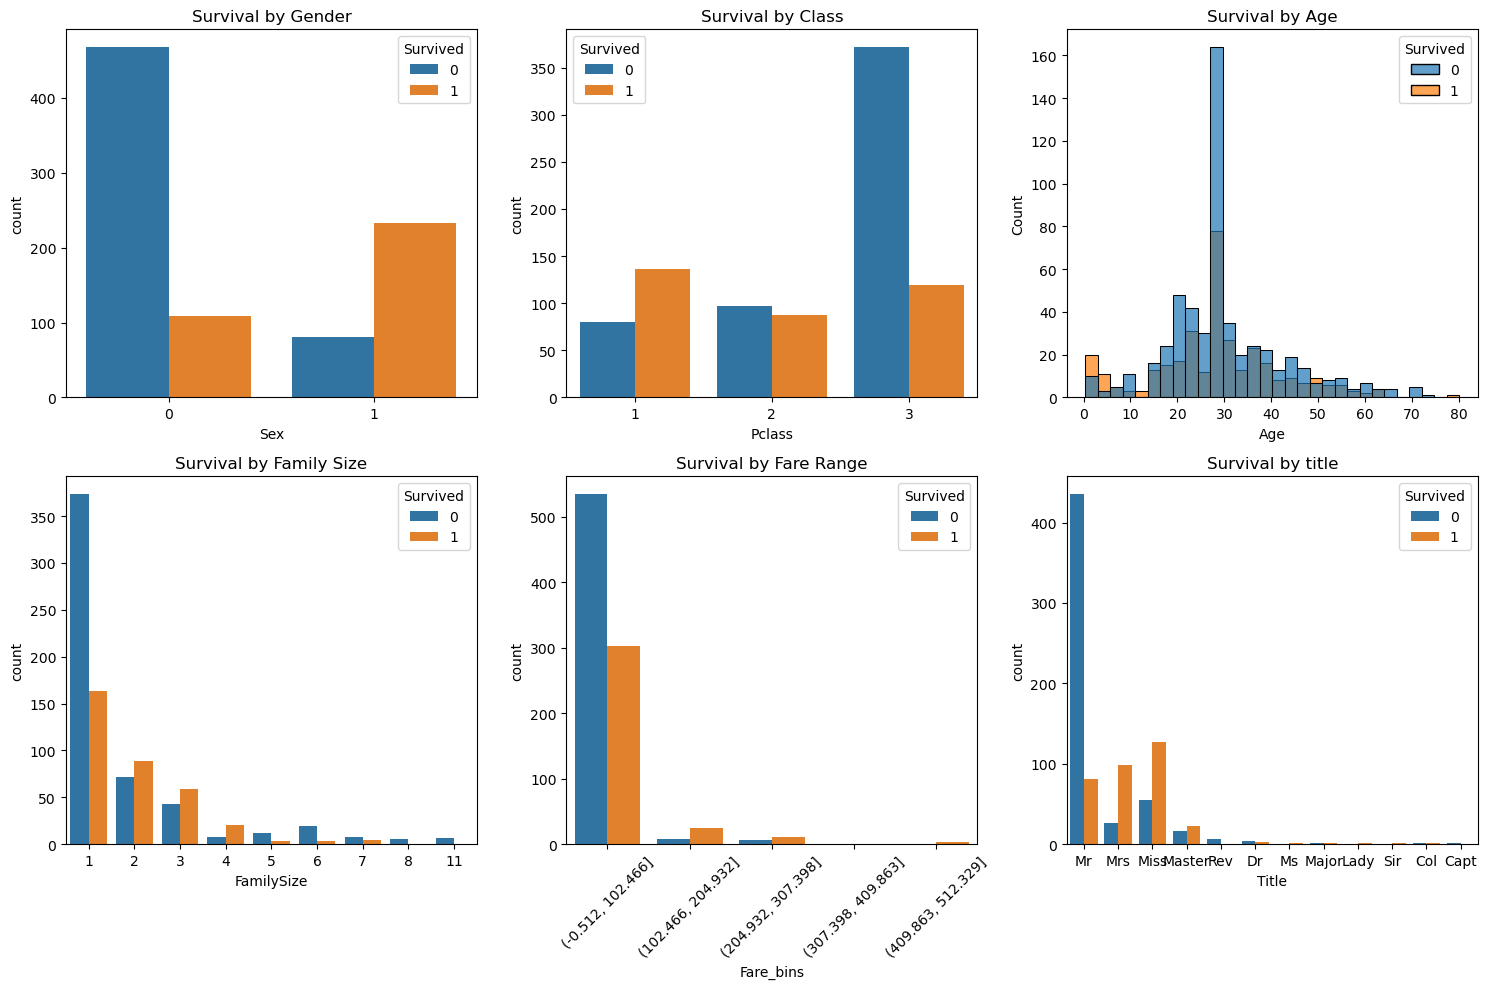

In [93]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.countplot(data=train, x='Sex', hue='Survived')
plt.title('Survival by Gender')

plt.subplot(2, 3, 2)
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.title('Survival by Class')

plt.subplot(2, 3, 3)
sns.histplot(data=train, x='Age', hue='Survived', bins=30, alpha=0.7)
plt.title('Survival by Age')

plt.subplot(2, 3, 4)
sns.countplot(data=train, x='FamilySize', hue='Survived')
plt.title('Survival by Family Size')

plt.subplot(2, 3, 5)
train['Fare_bins'] = pd.cut(train['Fare'], bins=5)
sns.countplot(data=train, x='Fare_bins', hue='Survived')
plt.title('Survival by Fare Range')
plt.xticks(rotation=45)

plt.subplot(2, 3, 6)
sns.countplot(data=train, x='Title', hue='Survived')
plt.title('Survival by title')

plt.tight_layout()
plt.show()

In [94]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']

X = train[features]
y = train['Survived']
X_test = test[features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

clf = XGBClassifier(
    random_state=42,
    n_estimators=400,
    max_depth=12,
    learning_rate=0.01,
    scale_pos_weight=1.5,
    subsample=0.8,
    colsample_bytree=1,
)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val) 
y_test_pred = clf.predict(X_test) 


print("=== Vyhodnocení na trénovací sadě ===")
print(f"Balanced accuracy na trénovací sadě: {balanced_accuracy_score(y_train, y_train_pred):.3f}")
print("Matice záměn:\n", confusion_matrix(y_train, y_train_pred))
print("Report:\n", classification_report(y_train, y_train_pred))

print("\n=== Vyhodnocení na validační sadě ===")
print(f"Balanced accuracy na validační sadě: {balanced_accuracy_score(y_val, y_val_pred):.3f}")
print("Matice záměn:\n", confusion_matrix(y_val, y_val_pred))
print("Report:\n", classification_report(y_val, y_val_pred))

print(f"\n=== Predikce na testovací sadě ===")
print(f"Predikovaná míra přežití: {y_test_pred.mean():.3f}")
print(f"Celkem predikcí: {len(y_test_pred)}")

=== Vyhodnocení na trénovací sadě ===
Balanced accuracy na trénovací sadě: 0.918
Matice záměn:
 [[424  20]
 [ 32 236]]
Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       444
           1       0.92      0.88      0.90       268

    accuracy                           0.93       712
   macro avg       0.93      0.92      0.92       712
weighted avg       0.93      0.93      0.93       712


=== Vyhodnocení na validační sadě ===
Balanced accuracy na validační sadě: 0.802
Matice záměn:
 [[89 16]
 [18 56]]
Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       105
           1       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179


=== Predikce na testovací sadě ===
Predikovaná míra přežití: 0.395
Celkem predikcí: 418


In [96]:
feature_imp = pd.DataFrame({
    'feature': features,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_imp)

      feature  importance
1         Sex    0.679428
0      Pclass    0.127662
3       SibSp    0.057328
6  FamilySize    0.041459
5        Fare    0.032920
2         Age    0.032137
4       Parch    0.029066
7     IsAlone    0.000000


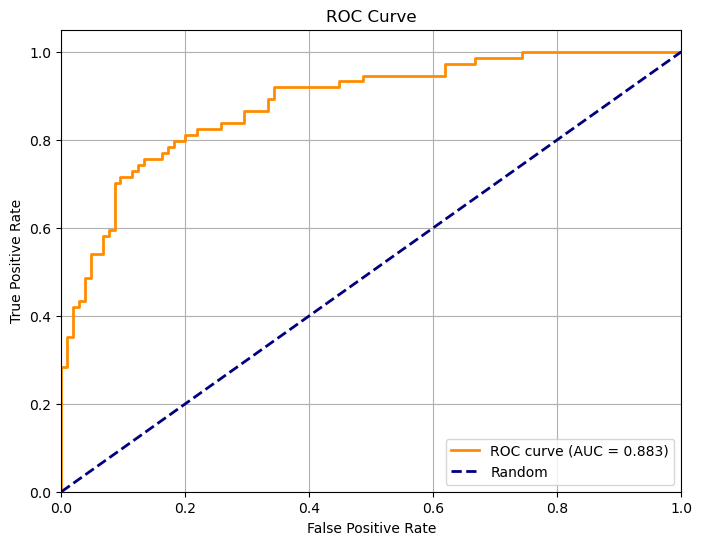

AUC Score: 0.883


In [97]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_val_proba = clf.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc:.3f}")

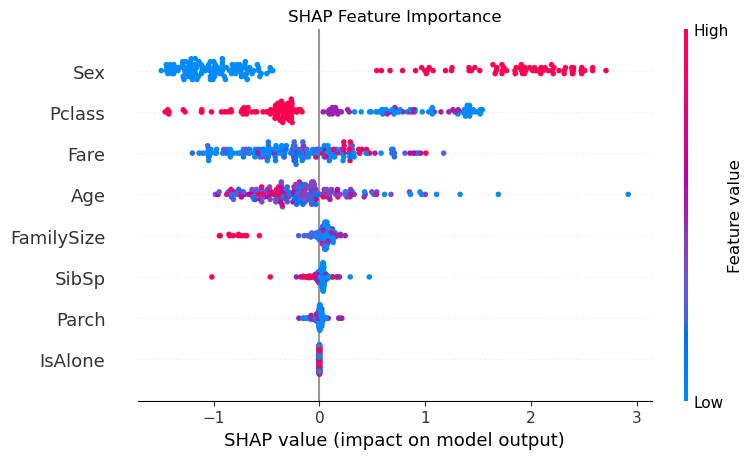

In [98]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_val)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val, feature_names=features, show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

In [99]:
submission = pd.read_csv('submission.csv')

In [100]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
